In [1]:
import fastbook
fastbook.setup_book()
print("ok")

ok


In [2]:
from fastai.vision.all import *
from fastbook import *
print("ok")

ok


In [3]:
print(URLs.MNIST)
path = untar_data(URLs.MNIST)

https://s3.amazonaws.com/fast-ai-imageclas/mnist_png.tgz


In [5]:
path.ls()

(#2) [Path('/home/john/.fastai/data/mnist_png/testing'),Path('/home/john/.fastai/data/mnist_png/training')]

In [7]:
(path/'training').ls()

(#10) [Path('/home/john/.fastai/data/mnist_png/training/7'),Path('/home/john/.fastai/data/mnist_png/training/6'),Path('/home/john/.fastai/data/mnist_png/training/2'),Path('/home/john/.fastai/data/mnist_png/training/4'),Path('/home/john/.fastai/data/mnist_png/training/0'),Path('/home/john/.fastai/data/mnist_png/training/5'),Path('/home/john/.fastai/data/mnist_png/training/9'),Path('/home/john/.fastai/data/mnist_png/training/1'),Path('/home/john/.fastai/data/mnist_png/training/3'),Path('/home/john/.fastai/data/mnist_png/training/8')]

In [13]:
im0 = Image.open(path/'training'/'0'/'4356.png')
im0

In [16]:
im0_t = tensor(im0)
df = pd.DataFrame(im0_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Blues')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,157,254,255,190,82,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,15,162,253,253,253,246,107,4,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,60,240,253,253,253,253,253,253,118,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,60,228,253,253,253,253,253,253,253,217,16,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,213,253,253,253,253,253,253,253,253,253,122,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,105,247,253,253,253,237,198,104,240,253,253,232,27,0,0,0,0,0,0,0


In [30]:
def stack(dir):
    return torch.stack([tensor(Image.open(f)) for f in dir.ls()]).float()/255

stacks = [stack(dir) for dir in (path/'training').ls().sorted()]
means = [s.mean(0) for s in stacks]

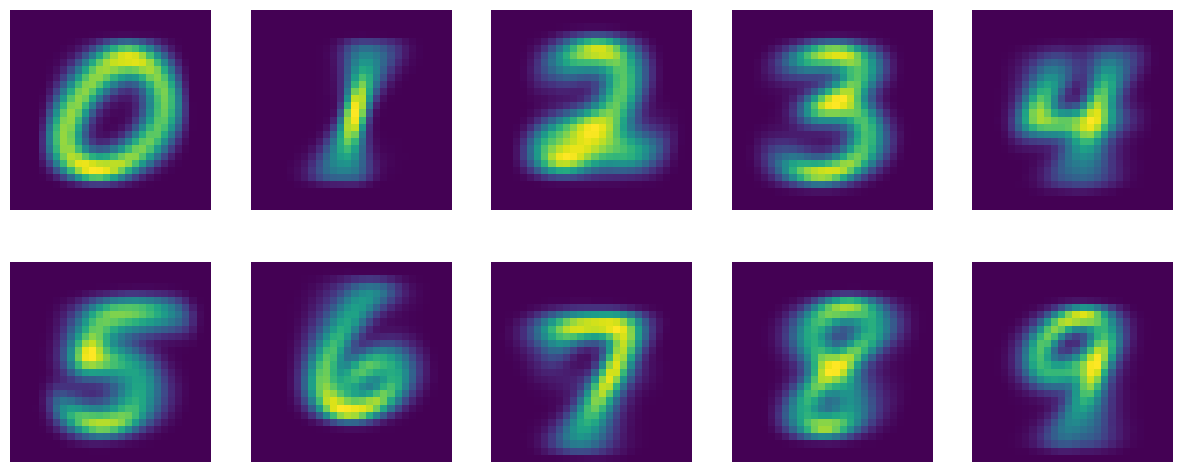

In [34]:
show_images(means, nrows=2)

In [33]:
df = pd.DataFrame(means[0])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000085,0.000168,0.000069,0.000000,0.000060,0.000163,0.000077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000019,0.000007,0.000000,0.000056,0.000132,0.000029,0.000000,0.000000,0.000061,0.000187,0.000311,0.000130,0.000115,0.000152,0.000013,0.000050,0.000090,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000056,0.000082,0.000256,0.000219,0.000243,0.000460,0.000865,0.001962,0.004878,0.008332,0.012326,0.015042,0.017826,0.018416,0.014961,0.011169,0.009312,0.006488,0.003235,0.001294,0.000468,0.000169,0.000048,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000107,0.000109,0.000219,0.000761,0.002083,0.005711,0.014118,0.027904,0.054995,0.099164,0.154879,0.205981,0.248931,0.260595,0.240422,0.194918,0.141541,0.084851,0.042668,0.017148,0.004004,0.000720,0.000115,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000177,0.000215,0.000599,0.002843,0.007532,0.019297,0.046408,0.094427,0.171725,0.272110,0.389630,0.491864,0.563113,0.589211,0.552305,0.464550,0.350413,0.225110,0.123733,0.052587,0.014197,0.002005,0.000093,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000690,0.002849,0.007167,0.019234,0.049314,0.108448,0.202641,0.326746,0.460440,0.585968,0.677657,0.736065,0.754336,0.738108,0.672338,0.546734,0.397835,0.244500,0.120219,0.038761,0.004982,0.000259,0.000054,0.000048
7,0.000000,0.000000,0.000000,0.000054,0.000782,0.004625,0.013701,0.042175,0.101458,0.202828,0.334253,0.477150,0.598377,0.680130,0.724908,0.738640,0.744723,0.754336,0.739464,0.669955,0.539562,0.373508,0.211797,0.081022,0.013957,0.000658,0.000007,0.000102
8,0.000035,0.000000,0.000061,0.000105,0.000927,0.006841,0.027937,0.082318,0.180540,0.315460,0.464521,0.590253,0.664073,0.678369,0.654312,0.620124,0.604748,0.618934,0.663354,0.683655,0.630319,0.488060,0.307741,0.135513,0.028014,0.000490,0.000000,0.000000
9,0.000000,0.000000,0.000028,0.000186,0.001664,0.012902,0.055203,0.145744,0.277478,0.435797,0.573786,0.650874,0.653874,0.598884,0.512297,0.439463,0.399462,0.421223,0.508257,0.613340,0.648630,0.570167,0.400664,0.196729,0.045868,0.000596,0.000000,0.000000
